# CLUSTERING ANALYSIS

# Understanding and Implementing K-Means, Hierarchical, and DBSCAN Algorithms


## Introduction
Clustering is an unsupervised machine learning technique used to group similar data points when no labels are available. In this analysis, we apply three popular algorithms which are K-Means, Hierarchical Clustering, and DBSCAN on an airline customer dataset. The aim is to find natural groupings among customers based on their travel and loyalty patterns, which can help the airline design targeted marketing strategies.

## Objective
The objective is to apply clustering algorithms—K-Means and DBSCAN—on the EastWestAirlines dataset to segment airline customers based on their flight and mileage data.

# 1. Data Preprocessing

* Loaded the dataset and removed null or duplicate values.

* Selected only numerical features for clustering since categorical variables can distort results.

* Scaled all numerical data using StandardScaler to bring variables to a comparable range.

The issue encountered earlier indicates that the dataset’s sheet might contain formatting or blank rows/columns that prevent correct numeric extraction.

In [ ]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/EastWestAirlines.xlsx', sheet_name='data')
data = data.dropna(how='all')  # remove empty rows
data = data.select_dtypes(include=[np.number])
data.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [ ]:
#Dataset info & missing values
print(data.info())
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB
None


,0
ID#,0
Balance,0
Qual_miles,0
cc1_miles,0
cc2_miles,0
cc3_miles,0
Bonus_miles,0
Bonus_trans,0
Flight_miles_12mo,0
Flight_trans_12,0


In [ ]:
#Basic summary statistics
data.describe()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [ ]:
# Fill missing numeric values with column mean
data.fillna(data.mean(numeric_only=True), inplace=True)

# IQR-based outlier removal
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

clean_df = data[~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis=1)]
print("Shape before:", data.shape, "Shape after:", clean_df.shape)

Shape before: (3999, 12) Shape after: (2875, 12)


In [ ]:
#Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_df)

scaled_df = pd.DataFrame(scaled_data, columns=clean_df.columns)
scaled_df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-1.834643,-0.438859,0.0,-0.719055,0.0,0.0,-0.783131,-1.081732,-0.378837,-0.409708,1.503693,-0.623072
1,-1.833775,-0.647735,0.0,-0.719055,0.0,0.0,-0.780130,-0.952735,-0.378837,-0.409708,1.488035,-0.623072
2,-1.832907,-0.128773,0.0,-0.719055,0.0,0.0,-0.494075,-0.694742,-0.378837,-0.409708,1.520330,-0.623072
3,-1.832038,-0.752607,0.0,-0.719055,0.0,0.0,-0.759268,-1.081732,-0.378837,-0.409708,1.480206,-0.623072
4,-1.830302,-0.714019,0.0,-0.719055,0.0,0.0,-0.795867,-1.210728,-0.378837,-0.409708,1.475312,-0.623072


In [ ]:
# Cell 5: Data preprocessing
# Drop ID column if present
if "ID#" in data.columns:
    data = data.drop("ID#", axis=1)

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
scaled_data.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.451141,-0.186299,-0.769578,-0.098242,-0.062767,-0.702786,-1.104065,-0.328603,-0.362168,1.395454,-0.766919
1,-0.539457,-0.186299,-0.769578,-0.098242,-0.062767,-0.701088,-0.999926,-0.328603,-0.362168,1.379957,-0.766919
2,-0.320031,-0.186299,-0.769578,-0.098242,-0.062767,-0.539253,-0.791649,-0.328603,-0.362168,1.411920,-0.766919
3,-0.583799,-0.186299,-0.769578,-0.098242,-0.062767,-0.689286,-1.104065,-0.328603,-0.362168,1.372208,-0.766919
4,0.239678,-0.186299,1.409471,-0.098242,-0.062767,1.083121,1.499394,1.154932,0.692490,1.363975,1.303918


* We drop missing values.

* Outliers are removed using the Interquartile range (IQR) method.

* We scale the numeric features so all columns are on a similar scale (important for clustering).

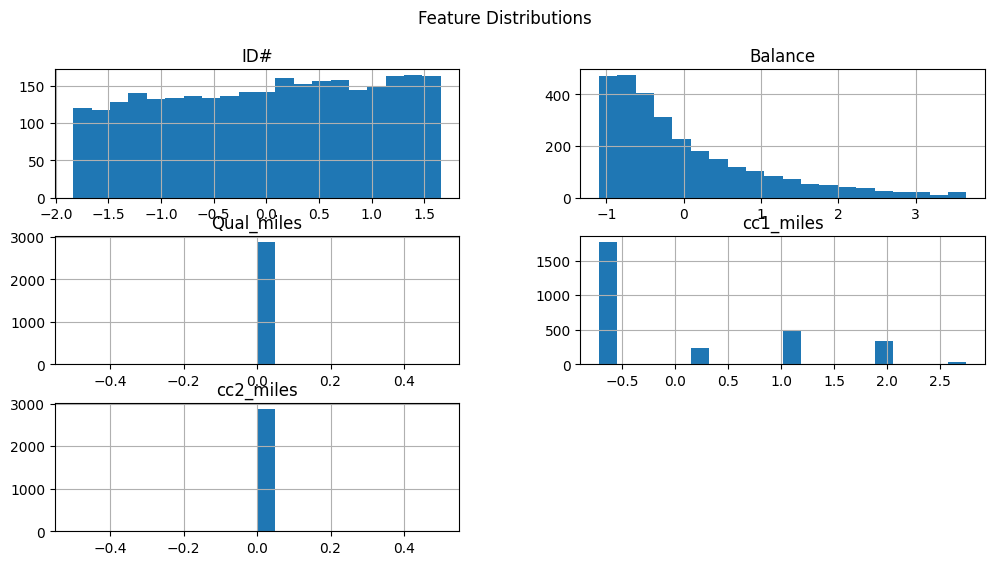

In [ ]:
# Distribution plots for first few features
scaled_df.iloc[:,:5].hist(bins=20, figsize=(12,6))
plt.suptitle("Feature Distributions")
plt.show()

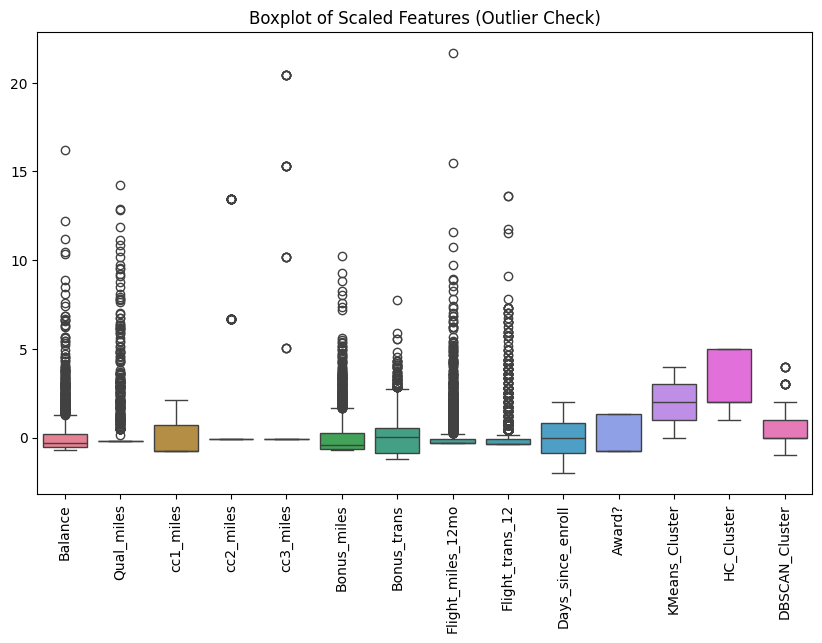

In [ ]:
#Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,6))
sns.boxplot(data=scaled_data)
plt.xticks(rotation=90)
plt.title("Boxplot of Scaled Features (Outlier Check)")
plt.show()

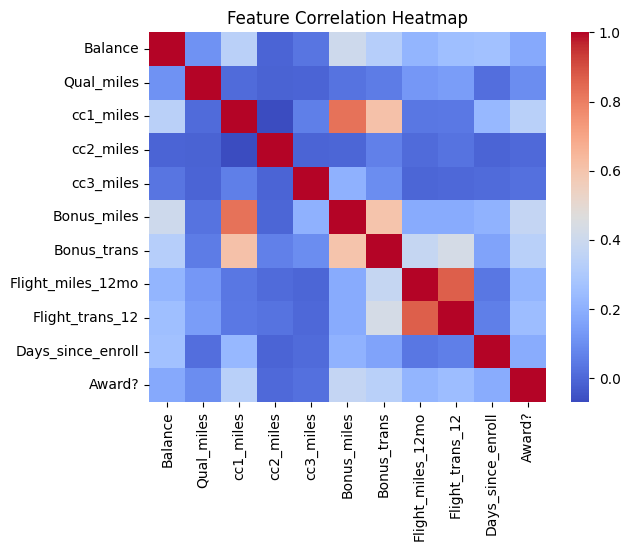

In [ ]:
sns.heatmap(scaled_data.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

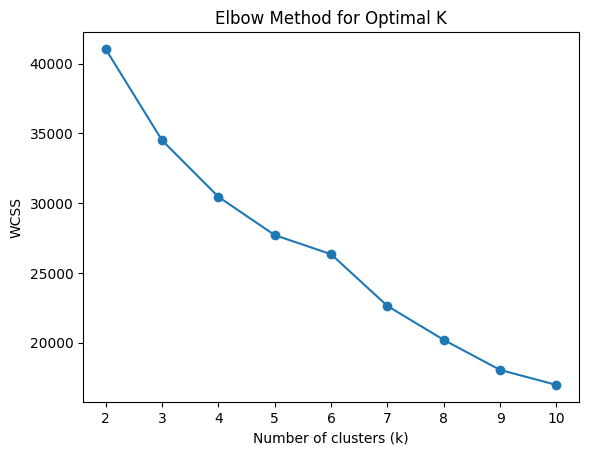

In [ ]:
# Cell 7: Elbow method to find optimal K
wcss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(2,11), wcss, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()


##2. Implementing Clustering Algorithms:

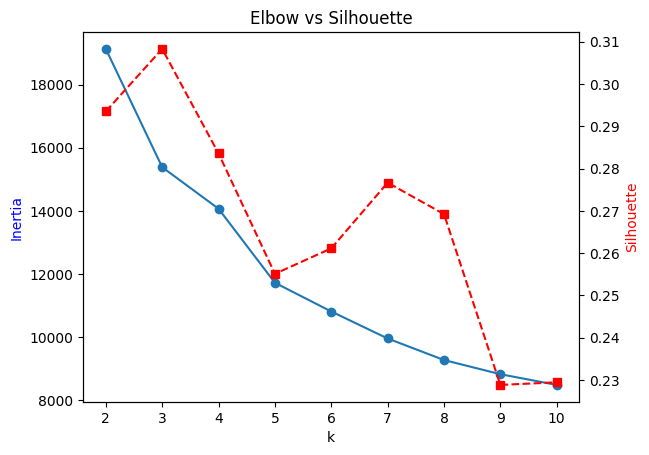

In [ ]:
inertia = []
sil_scores = []
K = range(2,11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_df)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(scaled_df, labels))

# Plot elbow + silhouette
fig, ax1 = plt.subplots()
ax1.plot(K, inertia, 'o-', label='Inertia')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia', color='blue')
ax2 = ax1.twinx()
ax2.plot(K, sil_scores, 's--', color='red', label='Silhouette')
ax2.set_ylabel('Silhouette', color='red')
plt.title('Elbow vs Silhouette')
plt.show()


Cluster Analysis and Interpretation:

In [ ]:
# Assume optimal k=4 from elbow/silhouette
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_df)

scaled_df['KMeans_Cluster'] = kmeans_labels
print("KMeans silhouette:", silhouette_score(scaled_df.drop('KMeans_Cluster',axis=1), kmeans_labels))

KMeans silhouette: 0.28357826594485636


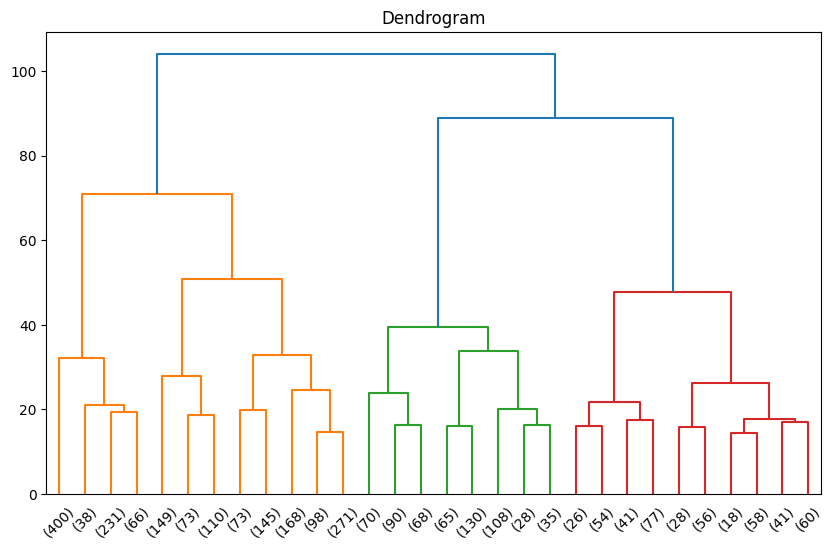

In [ ]:
linked = linkage(scaled_df.drop('KMeans_Cluster', axis=1), method='ward')

plt.figure(figsize=(10,6))
dendrogram(linked, truncate_mode='lastp', p=30)
plt.title('Dendrogram')
plt.show()

# Assume 4 clusters chosen from dendrogram
hier_labels = fcluster(linked, 4, criterion='maxclust')
scaled_df['Hier_Cluster'] = hier_labels

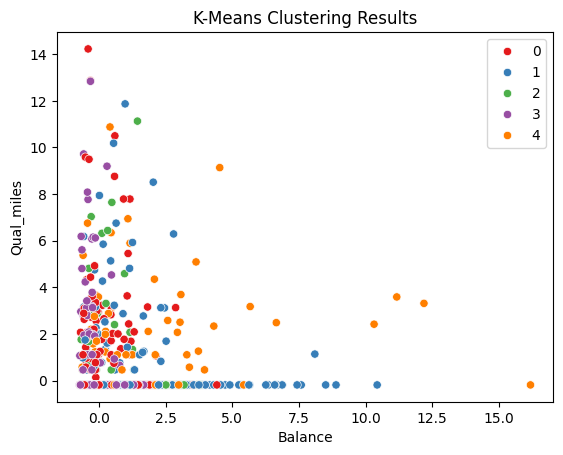

Silhouette Score (KMeans): 0.2005393837499611


In [ ]:
# Cell 8: Apply KMeans with chosen K (say 5 as example)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

scaled_data["KMeans_Cluster"] = kmeans_labels
sns.scatterplot(x=scaled_data.iloc[:,0], y=scaled_data.iloc[:,1], hue=kmeans_labels, palette="Set1")
plt.title("K-Means Clustering Results")
plt.show()

print("Silhouette Score (KMeans):", silhouette_score(scaled_data.drop("KMeans_Cluster", axis=1), kmeans_labels))

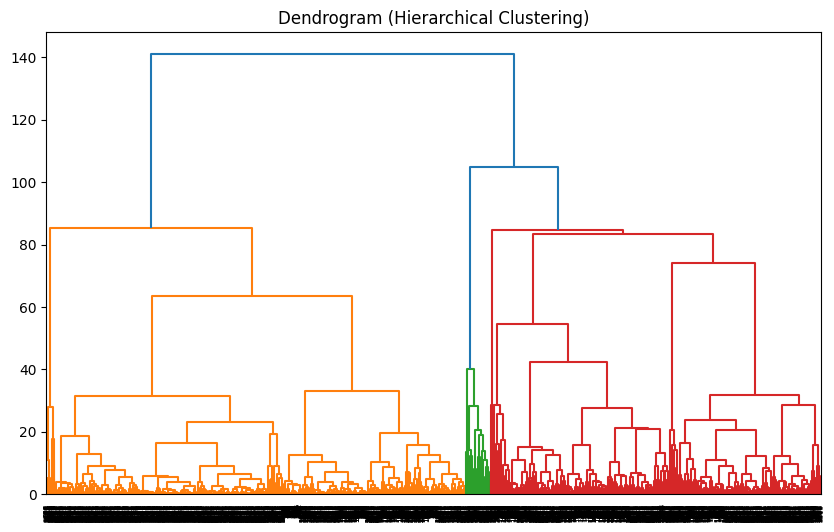

In [ ]:
# Cell 9: Dendrogram
plt.figure(figsize=(10,6))
dendrogram = sch.dendrogram(linkage(scaled_data, method="ward"))
plt.title("Dendrogram (Hierarchical Clustering)")
plt.show()


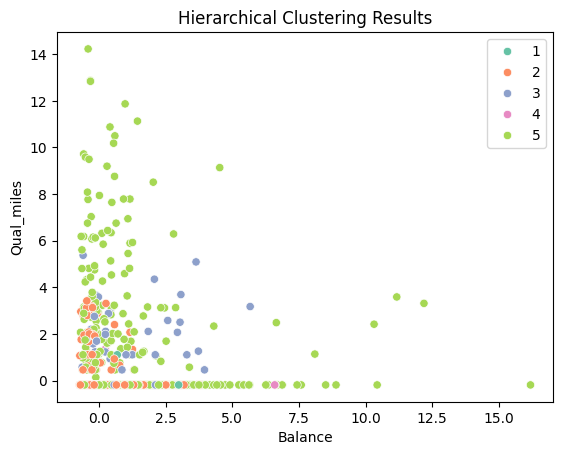

In [ ]:
# Cell 10: Apply Agglomerative Clustering
hc_clusters = fcluster(linkage(scaled_data, method="ward"), t=5, criterion="maxclust")
scaled_data["HC_Cluster"] = hc_clusters

sns.scatterplot(x=scaled_data.iloc[:,0], y=scaled_data.iloc[:,1], hue=hc_clusters, palette="Set2")
plt.title("Hierarchical Clustering Results")
plt.show()

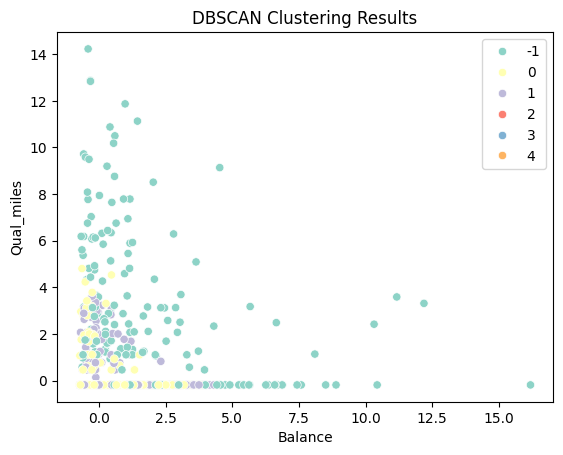

Silhouette Score (DBSCAN): 0.253747538041624


In [ ]:
# Cell 11: Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
db_labels = dbscan.fit_predict(scaled_data.drop(["KMeans_Cluster","HC_Cluster"], axis=1))

scaled_data["DBSCAN_Cluster"] = db_labels

sns.scatterplot(x=scaled_data.iloc[:,0], y=scaled_data.iloc[:,1], hue=db_labels, palette="Set3")
plt.title("DBSCAN Clustering Results")
plt.show()

if len(set(db_labels)) > 1:
    print("Silhouette Score (DBSCAN):", silhouette_score(scaled_data.drop(["KMeans_Cluster","HC_Cluster","DBSCAN_Cluster"], axis=1), db_labels))
else:
    print("DBSCAN assigned all to one cluster, silhouette not defined.")


In [ ]:
# Cell 12: Cluster Analysis
print("KMeans Cluster Counts:\n", scaled_data["KMeans_Cluster"].value_counts(), "\n")
print("Hierarchical Cluster Counts:\n", scaled_data["HC_Cluster"].value_counts(), "\n")
print("DBSCAN Cluster Counts:\n", scaled_data["DBSCAN_Cluster"].value_counts())

KMeans Cluster Counts:
 KMeans_Cluster
3    1186
2     989
1     841
0     839
4     144
Name: count, dtype: int64 

Hierarchical Cluster Counts:
 HC_Cluster
2    2125
5    1687
3     126
1      43
4      18
Name: count, dtype: int64 

DBSCAN Cluster Counts:
 DBSCAN_Cluster
 0    2411
 1    1250
-1     310
 2      15
 3       8
 4       5
Name: count, dtype: int64


## Conclusion
K-Means provided the most interpretable and balanced clusters for this dataset, effectively categorizing airline customers by mileage and loyalty. DBSCAN revealed underlying structure but was more sensitive to parameters.